# [TPS-Aug] EDA
This competition is a predicting a target loss based on a number of feature columns given in the data.

The metric used in this competition is Root Mean Squared Error, a regression metric:

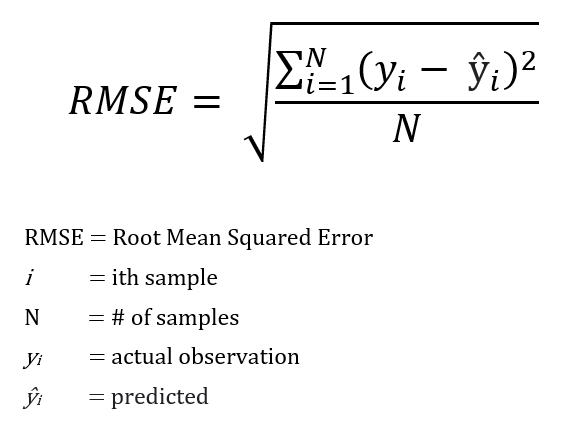

**Basic concepts**
Expalanation taken from [this thread](https://www.kaggle.com/c/tabular-playground-series-aug-2021/discussion/256337)

<blockquote>
PD=Probability of default: Generally defined on when a borrower doesn't pay off above a certain threshold for a long time. 
    
EAD=Exposure at Default : Exposure at default: Typically, every financial product has a max EAD defined, upon crossing which one is considered a defaulter.    
LGD=Loss Given Default: Loss given default is the percentage of EAD that cant be recovered. Certain part of a defaulter's loan can be reclaimed by recovery/settlement etc., but this amount absolutely cant be.
</blockquote>


**Contents**

- [Import Library & Default Setting](#1)
- [Dataset Check](#2)
- [Target Distribution](#3)
- [Table EDA](#4)
- [Features Distribution](#5)
- [Correlation](#6)
- [Conclusion](#7)



It is based on [amazing kernel](https://www.kaggle.com/subinium/tps-may-categorical-eda) by [@subinium](https://www.kaggle.com/subinium)

# <a id="1"/>1. Import Library & Default Setting


In [ ]:
# import libs
import warnings

import numpy as np
import pandas as pd 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px

# setting up options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# <a id="2"/>2. Dataset Check

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv')
test = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')

In [ ]:
print(f"Shape of train dataframe:", train.shape)

Train dataframe

In [ ]:
train.head()

In [ ]:
print(f"Shape of test dataframe:", test.shape)

Test dataframe:

In [ ]:
test.head()

In [ ]:
train = train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

# <a id="3"/>Target Distribution


In [ ]:
fig = px.histogram(train, x="loss", title='Target Distribution')
fig.update_layout(bargap=0.2)
fig.show()

In [ ]:
train['loss'].describe()

- There are a total of 43 discrete losses.(0-42)
- All except the order of 2 and 1 are in increasing order.
- All except are int64

Should remember:
> The ground truth loss is integer valued, although predictions can be continuous.

If I understand rightly, that loss is LGD=Loss Given Default.
> LGD: Loss given default is the percentage of EAD that cant be recovered. Certain part of a defaulter's loan can be reclaimed by recovery/settlement etc., but this amount absolutely cant be.

We can conclude that:
- most loans can be repaid in full. 
- Banks do not lose more than 42% of the loan
- only 25% of banks lose more than 10%

I couldn't find any mention in the Data tab that the data are synthetic, but I remember that before at the TPS competitions there were such. In particular, I'm confused that loss is only integer. So for now, let's keep in mind that the number 0 and the number 42 may not be the **percentage** that the bank can't get back, but some other characteristic.(?) 

# <a id="4"/> 3. Table EDA

## 3.1. Base statistical values of features

In [ ]:
train.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

In [ ]:
test.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

Comparison of statistics of train and test.

In [ ]:
def diff_color(x):
    color = 'red' if x<0 else ('green' if x > 0 else 'black')
    return f'color: {color}'

(train.describe() - test.describe())[test.columns].T.iloc[:,1:].style\
        .bar(subset=['mean', 'std'], align='mid', color=['#d65f5f', '#5fba7d'])\
        .applymap(diff_color, subset=['min', 'max'])

## 3.2. Features value counts

In [ ]:
nunique_df = train.nunique().to_frame().reset_index()
nunique_df = nunique_df.rename(columns={"index": "f", 0: "count_train"})

nunique_df_test = test.nunique().to_frame().reset_index()
nunique_df_test = nunique_df_test.rename(columns={"index": "f", 0: "count_test"})

nunique_df = nunique_df.merge(nunique_df_test, left_on="f", right_on="f")

fig = go.Figure(data=[
    go.Bar(name='Train', x=nunique_df['f'], y=nunique_df['count_train']),
    go.Bar(name='Test', x=nunique_df['f'], y=nunique_df['count_test'])
])
fig.update_layout(title_text='Number of unique values for each feature')
fig.show()

## 3.3. Features Distribution

In [ ]:
fig, axes = plt.subplots(25, 4, figsize=(10, 30))

target_order = sorted(train['loss'].unique())
for idx, ax in zip(range(100), axes.flatten()):
    sns.kdeplot(x=f'f{idx}', 
                hue='loss', hue_order=target_order,
                data=train,
                alpha=0.5, 
                linewidth=0.6, fill=True,
                legend=False,
                ax=ax)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    ax.set_title(f"f{str(idx)}", loc='center', weight='bold', fontsize=9)

axes.flatten()[-1].axis('off')    
axes.flatten()[-2].axis('off')

fig.supxlabel('Distribution by loss (by feature)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()

- 

# <a id="6"/> Correlation

In [ ]:
corr = train.corr()

for i in range(corr.shape[0]):
    corr.iloc[i,i] = None

In [ ]:

    
fig = px.imshow(corr, width=1000, height=1000)
fig.show()

Look at target correlation zoom:

In [ ]:
fig = px.imshow(corr['loss'].to_frame().T)
fig.show() 

There are weak correlations in the data(from -0.03 to 0.02)